In [1]:
import os
samples = os.listdir('/teamspace/studios/this_studio/Deeplab/crf_sam_annotations/samples')
%cd '/teamspace/studios/this_studio/sam-hq'
!export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide

/teamspace/studios/this_studio/sam-hq


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_11m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vi

In [2]:
    sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
    model_type = "vit_l"
    device = "cuda"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)


<All keys matched successfully>


In [1]:
%cd /teamspace/studios/this_studio/Deeplab/
from inference.infer import *
from post_processing.control_random_field import *

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/teamspace/studios/this_studio/Deeplab


In [2]:
def get_target(mask_path):
    mask = Image.open(mask_path)
    mask_array = np.array(mask)
    mask_array = (mask_array > 128).astype(np.uint8)
    mask_array = mask_array * 255
    mask = Image.fromarray(mask_array.astype(np.uint8))
    mask = mask_transform(mask)
    mask = torch.squeeze(mask, 0)
    mask = mask.to(device, dtype=torch.long)
    mask = mask.float()
    return mask.cpu().numpy()

def metrics_from_dataset(checkpoint, dataset_path):
    metrics = BinarySegMetrics()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_deeplab_model(checkpoint, device).eval()
    sample_dir = os.path.join(dataset_path, 'samples')
    mask_dir = os.path.join(dataset_path, 'binary_masks')

    file_list = os.listdir(sample_dir)

    for i in tqdm(file_list, desc="Processing images"):
        img_path = os.path.join(sample_dir, i)
        ext = os.path.basename(img_path).split('.')[-1]
        img_name = os.path.basename(img_path)[:-len(ext) - 1]
        mask_path = os.path.join(mask_dir, img_name + '_binarymask.' + ext)

        target = get_target(mask_path)
        img = Image.open(img_path)

        img_transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img_tensor = img_transform(img).unsqueeze(0).to(device, dtype=torch.float32)

        with torch.no_grad():
            output = model(img_tensor)
            output = torch.squeeze(output, dim=1)
            prob = torch.sigmoid(output).detach()
            pred = (prob > 0.5).long().cpu().numpy()[0]

        metrics.update(target, pred)

        # The following lines are commented out as they appear to be part of additional processing
        # denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # img_np = img_tensor[0].detach().cpu().numpy()
        # img_np = (denorm(img_np) * 255).transpose(1, 2, 0).astype(np.uint8)
        # cleaned_mask = apply_dense_crf(img_np, np.array(decode_target(pred)))
        # prob_np = prob[0].cpu().numpy()
        # count = np.sum(prob_np > 0.5)
        # confidence = np.sum(prob_np[prob_np > 0.5]) / count if count != 0 else 0

    return metrics.get_results()


In [3]:
import matplotlib.pyplot as plt
img_link = 'https://treetracker-production-images.s3.eu-central-1.amazonaws.com/2021.03.28.12.34.59_-4.531118333333334_38.248731666666664_6973c014-d0e7-4fa8-a80f-9495bfc8af3d_IMG_20210322_094829_8180242403936928723.jpg'
inhouse_default = '/teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth'
downstreamed_large = '/teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8495187035894669.pth'
downstreamed_small = '/teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8940880817269634.pth'
downstreamed_tuned = '/teamspace/studios/this_studio/Deeplab/saved_models/base_sam_dino_india_tuned_freetown_eastafrica_haiti_0.8213798905479425.pth'

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datasets import LeafDataset

from torchvision.io import read_image, write_jpeg
from torchvision.ops import masks_to_boxes

def remove_small_polygons(mask, threshold):
    if not isinstance(mask,np.ndarray):
        print('Takes a numpy array as input with entries either 0 or 255.')
        return
    segmentation = polygon_vertices(mask)
    poly_return = [polygon for polygon in segmentation if calculate_polygon_area(polygon) > threshold]
    binary_mask = np.zeros(mask.shape, dtype=np.uint8)
    for i in poly_return:
      pair = create_pair(i)
      polygon_points = np.array(pair, np.int32)
      cv2.fillPoly(binary_mask, [polygon_points], 255)
    return binary_mask/255

def decode_target_single_channel(mask):
    leaf_color = [255]
    rgb_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    rgb_mask[mask == 1] = leaf_color
    return Image.fromarray(rgb_mask)

def pil_to_grayscale_tensor(image):
    grayscale_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
    return grayscale_transform(image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_sam_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_mask(img_np, pred, input_box = None):
    plt.figure(figsize=(10, 10))
    # Create a blue mask based on the prediction
    blue_mask = np.zeros_like(img_np)
    blue_mask[:, :, 2] = pred * 255

    # Plot the image and the mask overlay
    plt.imshow(img_np)
    plt.imshow(blue_mask, alpha=0.7)
    if input_box is not None:
        show_box(input_box, plt.gca())

    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.show()
    plt.close()

def sam_predict(image, input_box):

    #image = image.astype(np.uint8)

    predictor.set_image(image)

    #input_box = np.array(boxes.tolist()[0])

    masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
    )

    print("SAM score for this mask is: " + str(scores[0]))

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_sam_mask(masks[0], plt.gca())
    show_box(input_box, plt.gca())
    plt.axis('off')
    plt.show()

def get_overlayed_mask(checkpoint, to_read, my_bucket=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_deeplab_model(checkpoint, device).eval()

    if isinstance(to_read, Image.Image):
        image = flip(to_read)
    elif is_url(to_read):
        response = requests.get(to_read)
        image = flip(Image.open(BytesIO(response.content)))
    elif is_s3_object_key(to_read) and my_bucket is not None:
        s3_object = my_bucket.Object(to_read).get()
        image = flip(Image.open(io.BytesIO(s3_object['Body'].read())))
    else:
        if not os.path.exists(to_read):
            print('Local path not valid.')
            return
        else:
            image = flip(Image.open(to_read))

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    plt.close()

    img_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = img_transform(image).unsqueeze(0).to(device, dtype=torch.float32)

    with torch.no_grad():
        output = model(img_tensor)
        output = torch.squeeze(output, dim=1)
        print(output.size())
        prob = torch.sigmoid(output).detach()
        print(prob.size())
        pred = (prob > 0.5).long().cpu().numpy()[0]

    denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_np = img_tensor[0].detach().cpu().numpy()
    img_np = (denorm(img_np) * 255).transpose(1, 2, 0).astype(np.uint8)

    prob_np = prob[0].cpu().numpy()
    count = np.sum(prob_np > 0.5)
    confidence = np.sum(prob_np[prob_np > 0.5]) / count if count != 0 else 0

    if count == 0:
        print('Nothing detected')
    else:
        print('Confidence is ' + str(confidence))
        print('Overlayed mask from deeplab:')
        show_mask(img_np, pred)

        poly_remove_mask = remove_small_polygons((pred * 255).astype(np.uint8), 100)
        show_mask(img_np, poly_remove_mask)
        cleaned_mask = crf_with_prob(img_np, np.array(decode_target_single_channel(pred)), prob_np)
        cleaned_mask_img = Image.fromarray((cleaned_mask * 255).astype(np.uint8))
        boxes = masks_to_boxes(pil_to_grayscale_tensor(cleaned_mask_img))
        box = np.array(boxes.tolist()[0])
        print('Overlayed mask after CRF:')
        show_mask(img_np, cleaned_mask, input_box=box)
        return box
        #sam_predict(img_np, box)
        #Deeplab/crf_sam_annotations/samples/eastafrica_acactort_2020.05.08.14.52.18_820f49c8-795b-453e-8eb1-7d473669ab84_img_20200507_152251_66198747.jpg



In [9]:
check = 'Deeplab/crf_sam_annotations/samples/eastafrica_gmelarbo_2022.03.24.06.55.28_2.9405984_32.344475949999996_71c97120-99fd-45ba-8cca-507b23f6aaba_img_20220314_142555_7984546332716014924.jpg'
use = '/teamspace/studios/this_studio/' + check


Device: cpu
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth


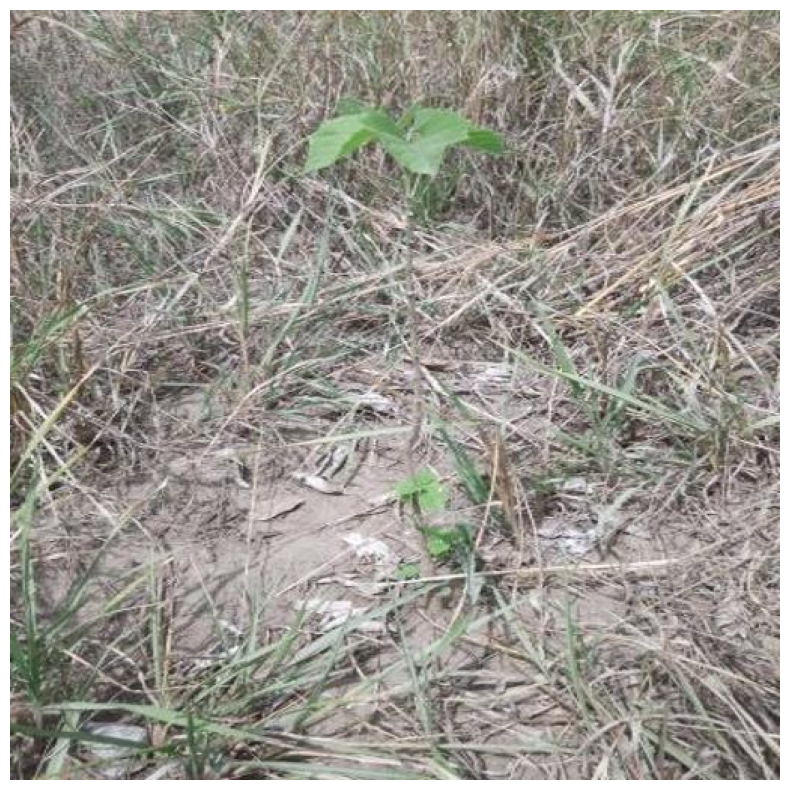

torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
Confidence is 0.9018262396100347
Overlayed mask from deeplab:


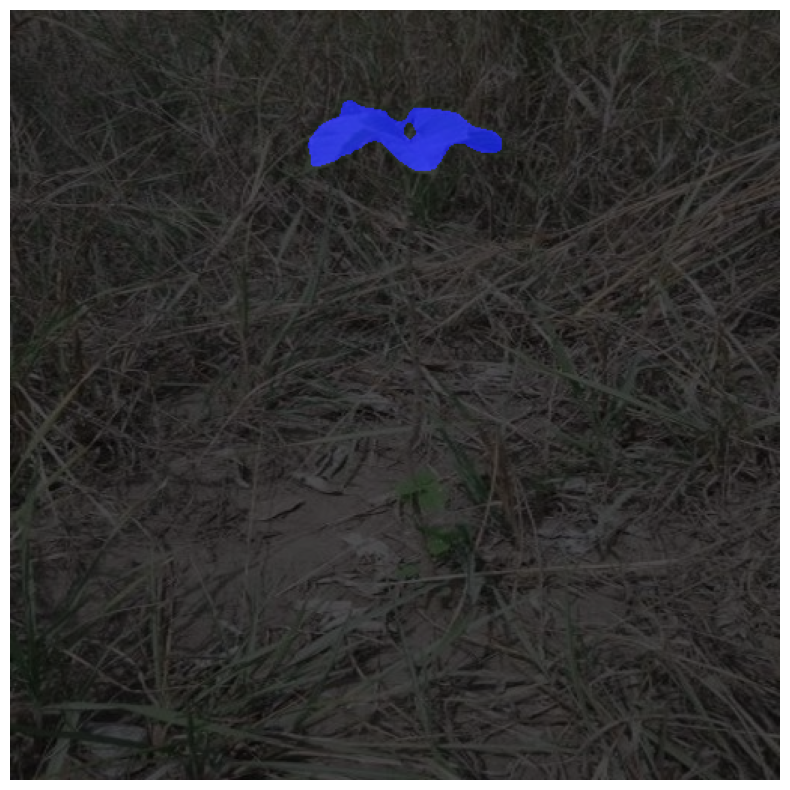

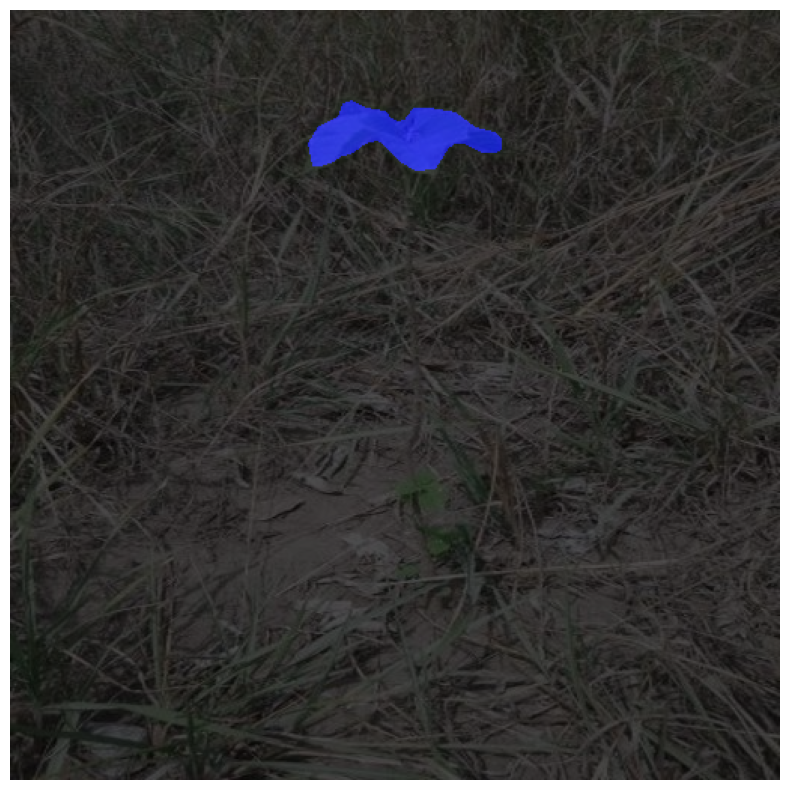

Overlayed mask after CRF:


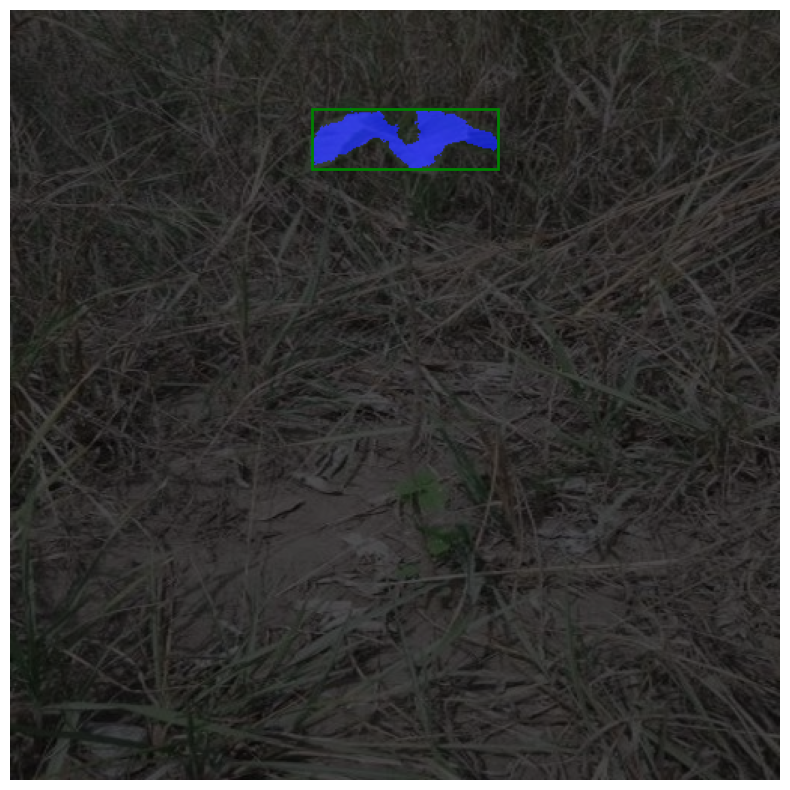

In [10]:
box = get_overlayed_mask(inhouse_default, use)

In [36]:
print(box)

[200.  65. 324. 105.]


In [37]:
from torch.nn.functional import threshold, normalize
def normalize_0_1(tensor):
    """
    Normalizes a tensor to the range [0, 1]
    """
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    return normalized_tensor
def get_prob(img_path, box):
    image = cv2.imread(img_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image_size = image.shape[:2]
    print(original_image_size)
    transform = ResizeLongestSide(sam.image_encoder.img_size)
    input_image_torch = torch.as_tensor(image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
    box = transform.apply_boxes(box, original_image_size)
    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
    box_torch = box_torch[None, :]
    print(box_torch)
    input_image = sam.preprocess(transformed_image)
    print('input_image size' + str(input_image.size()))
    input_size = tuple(transformed_image.shape[-2:])
    print(input_size)
    with torch.no_grad():
        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        #image_embedding = sam.image_encoder(input_image)
        features, interm_features = sam.image_encoder(input_image)
        low_res_masks, iou_predictions = sam.mask_decoder(
              image_embeddings=features,
              image_pe=sam.prompt_encoder.get_dense_pe(),
              sparse_prompt_embeddings=sparse_embeddings,
              dense_prompt_embeddings=dense_embeddings,
              multimask_output=False,
              hq_token_only = False,
              interm_embeddings = interm_features,
    
            )
        upscaled_masks = sam.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
        upscaled_masks = upscaled_masks > 0
    
    
    #return normalize(threshold(upscaled_masks, 0.0, 0))
    return upscaled_masks

In [18]:
use = '/teamspace/studios/this_studio/Deeplab/crf_sam_annotations/samples/eastafrica_gmelarbo_2022.03.24.07.07.09_3.046788223333333_32.41780353333333_05897093-f38d-4322-9fd5-58f4d99dca06_img_20220318_141135_467351189933291358.jpg'


In [11]:
prob_tensor = get_prob(use, box)

(512, 512)
tensor([[[132., 196., 946., 662.]]], device='cuda:0')
input_image sizetorch.Size([1, 3, 1024, 1024])
(512, 512)


In [ ]:
show_mask(np.array(Image.open(use)),pred)

In [28]:
prob_tensor = get_prob(use, np.array([0,0,512,512]))

(512, 512)
tensor([[[   0.,    0., 1024., 1024.]]], device='cuda:0')
input_image sizetorch.Size([1, 3, 1024, 1024])
(512, 512)


In [12]:
prob_numpy = prob_tensor.squeeze().cpu().numpy()

In [30]:
pred = (prob_numpy > 0.5)


In [34]:
print(pred)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


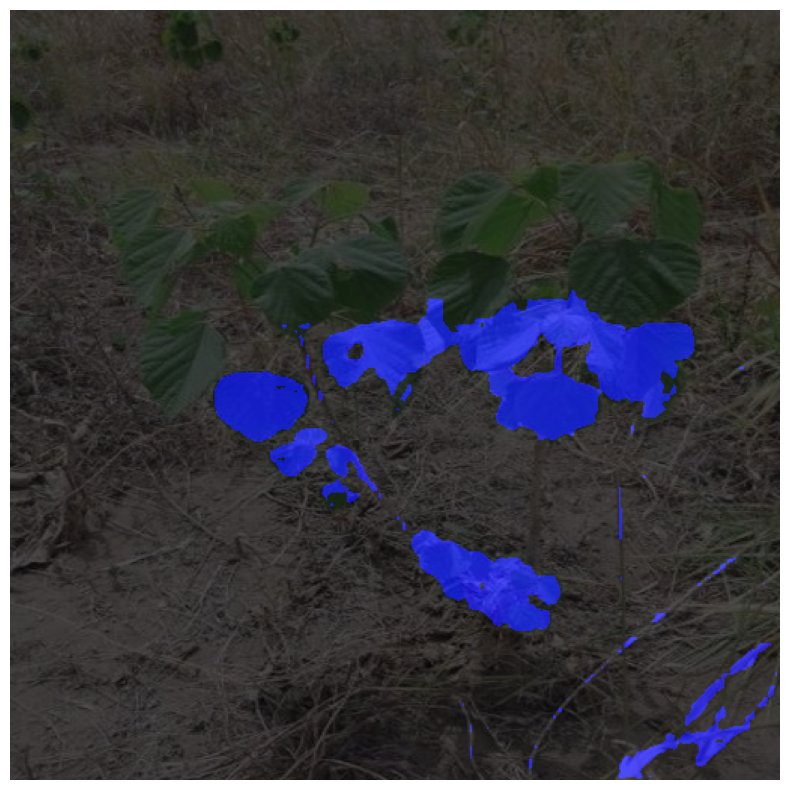

In [13]:
show_mask(np.array(Image.open(use)),prob_numpy)

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

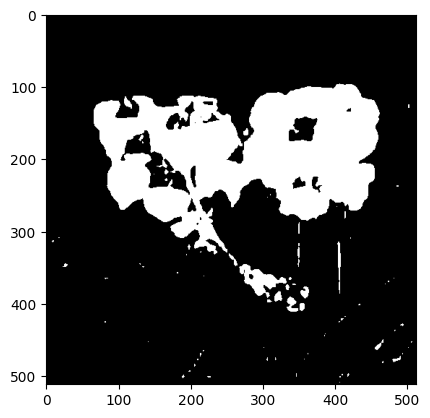

In [32]:
        pred_rgb = np.array(pred*255).astype(np.uint8)
        pred_image = Image.fromarray(pred_rgb).convert('RGB')
        plt.imshow(pred_image)
        plt.show()

In [38]:
#check = 'Deeplab/crf_sam_annotations/samples/eastafrica_albiziac_2023.01.03.22.42.48_-5.252749333333332_38.73406666666667_6f6bd305-079d-4726-ac1e-ddc1cc2b2579_img_20230103_161010_5841195937852867918.jpg'
#use = '/teamspace/studios/this_studio/' + check
predictor.set_image(np.array(Image.open(use)))
input_box =  box
masks, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
            return_logits = True,
        )
print(scores[0])
print(masks)
'''
plt.figure(figsize=(10, 10))
#plt.imshow(np.array(Image.open(use)))
show_mask(np.array(Image.open(use)), masks[0])
plt.axis('on')
plt.show()
plt.imshow(masks[0]*255)
plt.show()
'''

0.9410933
[[[-28.512596 -28.78291  -29.323538 ... -32.35433  -31.072384 -30.431412]
  [-28.703358 -29.05092  -29.746048 ... -33.005234 -31.74451  -31.114151]
  [-29.084877 -29.586939 -30.591064 ... -34.30704  -33.088768 -32.47963 ]
  ...
  [-32.541946 -32.630074 -32.806324 ... -33.04746  -33.926113 -34.36544 ]
  [-30.770355 -30.876904 -31.09     ... -31.66959  -32.009975 -32.180172]
  [-29.88456  -30.00032  -30.231838 ... -30.980656 -31.051908 -31.087536]]]


"\nplt.figure(figsize=(10, 10))\n#plt.imshow(np.array(Image.open(use)))\nshow_mask(np.array(Image.open(use)), masks[0])\nplt.axis('on')\nplt.show()\nplt.imshow(masks[0]*255)\nplt.show()\n"

In [22]:
array = masks.squeeze()
min_val = np.min(array)
max_val = np.max(array)
print(min_val)
print(max_val)
# Normalize the array to the range [0, 1]
#normalized_array = (array - min_val) / (max_val - min_val)

-24.741383
18.711674


In [24]:
normalized_array = (array - min_val) / (max_val - min_val)

# Verify that thresholding at 0.5 yields the same result as thresholding the original array at 0
original_binary_mask = masks.squeeze() > 0.0
normalized_binary_mask = normalized_array > 0.5

print("Original binary mask:")
print(original_binary_mask)

print("Normalized binary mask:")
print(normalized_binary_mask)

# Check if both masks are the same
print("Are the masks identical? ", np.array_equal(original_binary_mask, normalized_binary_mask))

Original binary mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Normalized binary mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Are the masks identical?  False


In [39]:
masks = masks > 0.0
print(masks)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


In [40]:
masks = masks.squeeze()

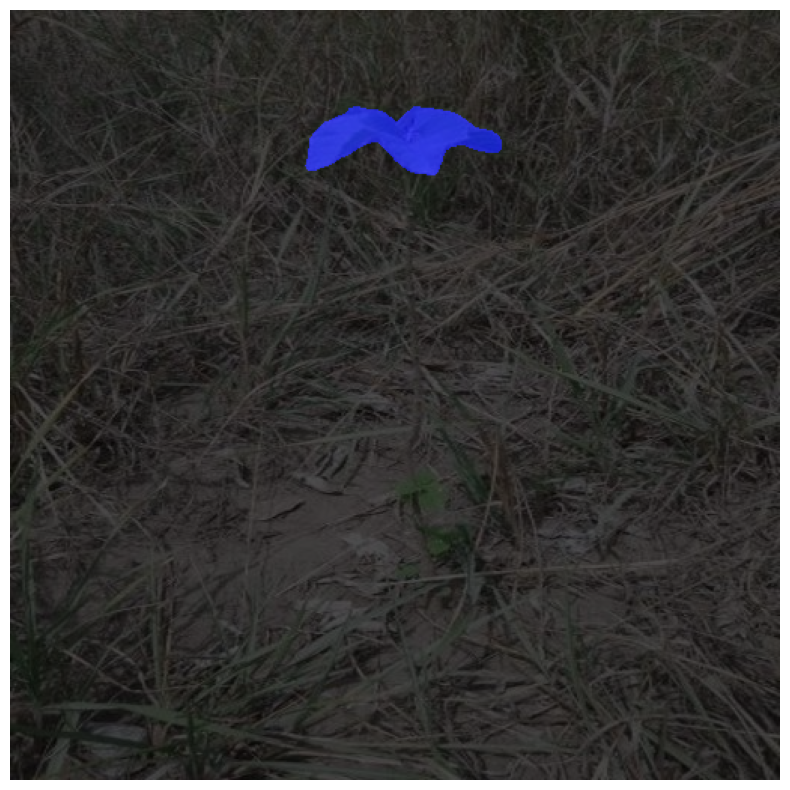

In [41]:
show_mask(np.array(Image.open(use)),masks)